# Imports

In [1]:
import gym # Contains Reinforcement Learning enviornments

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation # To create video of an episode
import pandas as pd

from IPython.display import clear_output
from IPython import display
from IPython.display import HTML

np.random.seed(1)

from collections import namedtuple, deque, defaultdict
import math
import random

import time
import json # To export data

In [2]:
# NN Libraries
# https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

/home/aaron/anaconda3/envs/ml/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Neural Network and RL Agent

In [3]:
# Adapted from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
# and https://github.com/philtabor/Youtube-Code-Repository/blob/master/ReinforcementLearning/DeepQLearning/simple_dqn_torch_2020.py

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class DQN(nn.Module):
    def __init__(self, lr, input_size, layer1_dims, layer2_dims, n_actions):
        """
        Basic neural network implementation for Deep Q Learning.
        
        lr: Learning Rate
        input_size: Size of the state
        layer1_dims: Dimensional size of layer 1
        layer2_dims: Dimensional size of layer 2
        n_actions: Number of actions
        """
        # Base class initialization
        super(DQN, self).__init__()
        
        # Neural network setup
        self.input_dims = input_size
        self.layer1_dims = layer1_dims
        self.layer2_dims = layer2_dims
        self.n_actions = n_actions
        
        # Neural Network Layers
        # First layer must have input size equal to the size of the state (input_size)
        self.layer1 = nn.Linear(input_size, self.layer1_dims)
        self.layer2 = nn.Linear(self.layer1_dims, self.layer2_dims)
        # Last layer must map to the number of actions (n_actions)
        self.layer3 = nn.Linear(self.layer2_dims, self.n_actions)

        # Neural Network Optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        
        # Neural Network Loss Function
        self.loss = nn.MSELoss()
        
        # Setup device to train on (GPU/CPU)
        self.device = device
        self.to(self.device)

    def forward(self, state):
        """
        Feed a state into the network.  Returns actions.
        """
        x = F.relu(self.layer1(state))
        x = F.relu(self.layer2(x))
        actions = self.layer3(x)
        
        return actions

/home/aaron/anaconda3/envs/ml/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# Adapted from https://www.katnoria.com/nb_dqn_lunar/
# and https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
class Replay_Memory():
    # Stores transitions in a queue
    def __init__(self, max_size=100000, batch_size=8, seed=-1):
        """
        Stores transition history of the enviornment to learn on.
        Additional details on Replay Memory can be read in DQNNaturPaper by Mnih, et al.
        """
        
        self.memory = deque(maxlen=max_size)
        
        self.batch_size = batch_size
        
        # Memory will store a set of transitions
        self.Transition = namedtuple('Transition', field_names=('state', 'action', 'reward', 'next_state', 'done'))
        
        # Set seed for sampling consistency
        if seed >= 0:
            random.seed(seed)
        
    def add(self, state, action, reward, next_state, done):
        """
        Add a transition to the memory
        """
        self.memory.append(self.Transition(state, action, reward, next_state, done))
        
    def sample(self):
        """
        Retrieve a sample of transitions to train on.
        Size of sample is determined by batch_size during initialization.
        """
        samples = random.sample(self.memory, k=self.batch_size)
        
        # Use float32 for Pytorch typing
        states = np.array([transition.state for transition in samples], dtype=np.float32)
        actions = np.array([transition.action for transition in samples], dtype=np.float32)
        rewards = np.array([transition.reward for transition in samples], dtype=np.float32)
        next_states = np.array([transition.next_state for transition in samples], dtype=np.float32)
        dones = np.array([transition.done for transition in samples], dtype=np.bool)
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        """
        Returns the number of transitions stored in the memory.
        """
        return len(self.memory)

In [5]:
class DQN_Agent():
    # Class that takes care of neural network and q memory
    def __init__(self, input_size, n_actions, lr=0.001, 
                 gamma=0.999, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.99,
                 max_mem_size=100000, batch_size=8, 
                 seed=-1, target_update_interval=10, use_target_net=True):
        """
        Agent used to implement Deep Q Learning algorithm.
        
        input_size: Size of the state.  Requried for neural network size.
        n_actions: Number of available actions.  Required for neural network size.
        lr: Learning rate
        gamma: Discount factor
        epsilon: The starting epsilon used to take greedy actions.
        epsilon_min: The minimum value epsilon can be (for epsilon decay)
        epsilon_decay: Reduces epsilon each update to the percentage of the previous epsilon.
                       Will not reduce epsilon below epsilon_min.
        max_mem_size: The max size of the replay memory
        batch_size: The size of the samples to learn on
        seed: A value to seed random and numpy libraries.  Seed must be greater than or equal to 0.
        target_update_interal: How many cycles before updating the target nueral network.
        use_taget_nut: Enables the use of a target network for updates (more stable).
        """
        if seed >= 0:
            random.seed(seed)
            np.random.seed(seed)
        
        self.gamma = gamma
        self.epsilon=epsilon
        self.n_actions = n_actions
        self.input_size = input_size
        self.lr = lr
        self.max_mem_size = max_mem_size
        
        # Initialize the memory storage
        self.memory = Replay_Memory(max_size=max_mem_size, batch_size=batch_size)
        self.batch_size = batch_size
        
        # Setup Neural Networks
        self.Q_policy_nn = DQN(lr, input_size, 64, 64, n_actions)
        self.Q_target_nn = DQN(lr, input_size, 64, 64, n_actions)
        self.Q_target_nn.load_state_dict(self.Q_policy_nn.state_dict())
        
        self.use_target_net = use_target_net
        
        # How offten to update the fixed target network
        self.target_update_interval = target_update_interval
        self.target_update_count = 0
        
        # Setup epsilon decay
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        
    def add_transition(self, state, action, reward, next_state, done):
        """
        Adds the state to memory.
        If the update_interval is reached, will learn on the current memory with batch_size.
        """
        self.memory.add(state, action, reward, next_state, done)
                
    def learn(self):
        """
        Learns from the batch of transitions.
        """
        
        # Return if there is not enough instances to create a batch
        if len(self.memory) < self.batch_size:
            return
        
        self.Q_policy_nn.optimizer.zero_grad()
        
        # Get a batch of memory
        states, actions, rewards, next_states, dones = self.memory.sample()
        states = torch.tensor(states).to(self.Q_policy_nn.device)
        rewards = torch.tensor(rewards).to(self.Q_policy_nn.device)
        next_states = torch.tensor(next_states).to(self.Q_policy_nn.device)
        dones = torch.tensor(dones).to(self.Q_policy_nn.device)
        
        
        batch_index = np.arange(self.batch_size, dtype=np.int32)
        
        q_eval = self.Q_policy_nn.forward(states)[batch_index, actions] # Q
        
        # Set q_next if target network is enabled
        if self.use_target_net:
            q_next = self.Q_target_nn.forward(next_states)
        else:
            q_next = self.Q_policy_nn.forward(next_states)
            
        q_next[dones] = 0 # Q terminal should be 0
        
        q_target = rewards + self.gamma *torch.max(q_next, dim=1)[0] # y
        
        loss = self.Q_policy_nn.loss(q_target, q_eval).to(self.Q_policy_nn.device) # error between y and Q in DQN paper
        loss.backward()
        self.Q_policy_nn.optimizer.step()
        
        # Decay epsilon
        if self.epsilon*self.epsilon_decay >= self.epsilon_min:
            self.epsilon = self.epsilon*self.epsilon_decay
        else:
            self.epsilon = self.epsilon_min

        # Update fixed target network
        self.target_update_count += 1
        if self.target_update_count % self.target_update_interval == 0:
            self.Q_target_nn.load_state_dict(self.Q_policy_nn.state_dict())        
        
    def select_action(self, state):
        """
        Takes an action based on epsilon greedy
        """
        if random.random() <= self.epsilon:
            action = np.random.randint(self.n_actions)
        else:
            tensor_state = torch.tensor([state]).to(self.Q_policy_nn.device)
            state_actions = self.Q_policy_nn.forward(tensor_state)
            action = torch.argmax(state_actions).item()
            
        return action

In [6]:
def create_episode_video(env, agent, text=''):
    """
    Creates a video showcasing an episode.
    The random action rate (epsilon) of the agent is temporarily changed to 0
    to ensure only the optimal action is taken
    """
    temp_epsilon = agent.epsilon
    agent.epsilon = -1
    
    frames = []
    state = env.reset()
    frames.append(env.render('rgb_array'))
    done = False
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, info = env.step(action)
        state = next_state
        frames.append(env.render('rgb_array'))
        
    agent.epsilon = temp_epsilon
    
    # Animation part adapted from: https://thecleverprogrammer.com/2020/07/26/openai-gym-in-machine-learning/
    fig = plt.figure()
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    patch = plt.imshow(frames[0])
    
    label = plt.text(frames[0].shape[1]/2, frames[0].shape[0]-30, text, ha='center', va='center', color='red', fontsize=20)
    
    def animate(i):
        patch.set_data(frames[i])
        return patch

    plt.axis('off')
    anim = animation.FuncAnimation(fig, animate, frames=len(frames), repeat=False, interval=50)
    plt.close()
    return anim
    

# Initial Training

In [7]:
env = gym.make('LunarLander-v2')
env.seed(1)
state = env.reset()

/home/aaron/anaconda3/envs/ml/lib/python3.9/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/aaron/anaconda3/envs/ml/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/aaron/anaconda3/envs/ml/lib/python3.9/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [8]:
'''
Inputs (8): (x, y, ẋ, ẏ, θ, θ̇ , leg L , leg R )
The state variables x and y are the horizontal and vertical position, ẋ and ẏ are the horizontal and vertical
speed, and θ and θ̇ are the angle and angular speed of the lander. Finally, leg L and leg R are binary values to
indicate whether the left leg or right leg of the lunar lander is touching the ground.

Actions (4): do nothing, fire the left orientation engine, fire the main engine, fire the right orientation engine.
'''
agent = DQN_Agent(gamma=0.99, epsilon=1.0, n_actions=env.action_space.n, input_size=len(state), lr=0.001,
                  epsilon_min=0.1, epsilon_decay=0.99995,
                  batch_size=64, max_mem_size=100000, target_update_interval=10)

In [ ]:
initial_training_data = {'scores':[], 'epsilons':[], 'gamma':agent.gamma, 'lr':agent.lr,
                         'epsilon_start':agent.epsilon, 'epsilon_min':agent.epsilon_min, 
                         'epsilon_decay':agent.epsilon_decay, 'batch_size':agent.batch_size,
                        'max_mem_size':agent.max_mem_size,
                         'target_update_interval':agent.target_update_interval}

scores = []
epsilons = []

episodes = 500

# Print training statistics every n episodes
print_every = 20

initial_training_data['epsiodes'] = episodes

model_episodes = set([1, 10, 25, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500])
for i in range(episodes):
    score = 0
    done = False
    state = env.reset()
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, info = env.step(action)
        score += reward
        agent.add_transition(state, action, reward, 
                                next_state, done)
        state = next_state
        
        #if counter % learn_n == 0:
        agent.learn()
        #counter += 1
    initial_training_data['scores'].append(score)
    initial_training_data['epsilons'].append(agent.epsilon)

    avg_score = np.mean(initial_training_data['scores'][-100:])
    if i%print_every == 0:
        print('Episode: {} \tScore: {:.2f} \tAverage Score: {:.2f} \tEpsilon: {:.2f}'.format(
             i, initial_training_data['scores'][i], avg_score, initial_training_data['epsilons'][i]))
        
    # Save model
    if i + 1 in model_episodes:
        torch.save(agent.Q_policy_nn.state_dict(), 'Q_policy_model_episodes_{}.pt'.format(i+1))

In [10]:
# Save model
q_policy_save_path = "Q_policy_model.pt"

torch.save(agent.Q_policy_nn.state_dict(), q_policy_save_path)

In [11]:
# Load model
q_policy_save_path = "Q_policy_model.pt"

agent.Q_policy_nn.load_state_dict(torch.load(q_policy_save_path))

<All keys matched successfully>

In [12]:
initial_train_file = 'initial_model.json'

In [13]:
# Save the data
with open(initial_train_file, 'w') as json_file:
    json.dump(initial_training_data, json_file)

In [14]:
# Load saved data
with open(initial_train_file, 'r') as json_file:
    initial_training_data = json.load(json_file)

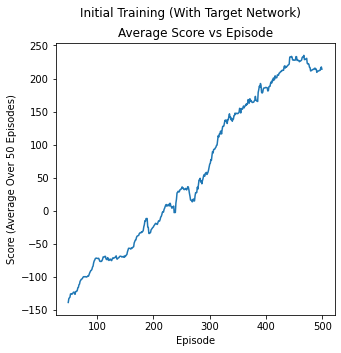

In [15]:
rolling_average = 50
avg_scores = pd.DataFrame(initial_training_data['scores']).rolling(rolling_average).mean()

fig, (ax1) = plt.subplots(1, 1, figsize=(5,5))

ax1.plot(range(len(avg_scores)), avg_scores)

ax1.set_xlabel("Episode")
ax1.set_ylabel("Score (Average Over {} Episodes)".format(rolling_average))
ax1.set_title("Average Score vs Episode")

fig.suptitle('Initial Training (With Target Network)')

plt.show()

In [16]:
# Create animation
vid = create_episode_video(env, agent, text='Test')

/home/aaron/anaconda3/envs/ml/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/aaron/anaconda3/envs/ml/lib/python3.9/site-packages/gym/core.py:51: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [17]:
# Save animation to file
vid.save('Lunar_Lander_Episode.mp4', writer='ffmpeg', fps=30)

In [18]:
# Play animation in notebook
html = display.HTML(vid.to_html5_video())
display.display(html)
plt.close() 

/home/aaron/anaconda3/envs/ml/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Create Videos of Model

In [19]:
create_videos = True
videos_per_model = 5

/home/aaron/anaconda3/envs/ml/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
if create_videos:
    model_episodes = set([1, 10, 25, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500])
    import os
    video_folder = 'videos'
    if not os.path.exists(video_folder):
        os.makedirs(video_folder)
        
    for episode in sorted(model_episodes):
        text = '{} episode'.format(episode) if episode == 1 else '{} episodes'.format(episode)
        text = 'Model after ' + text
        
        path = 'Q_policy_model_episodes_{}.pt'.format(episode)
        agent.Q_policy_nn.load_state_dict(torch.load(path))
        
        for i in range(videos_per_model):
            vid = create_episode_video(env, agent, text=text)
            vid.save('videos/Model_Episodes_{}_{}.mp4'.format(episode, i), writer='ffmpeg', fps=30)
            
    # Create additional videos for last model
    episode = sorted(model_episodes)[-1]
    path = 'Q_policy_model_episodes_{}.pt'.format(episode)
    agent.Q_policy_nn.load_state_dict(torch.load(path))
    text = '{} episode'.format(episode) if episode == 1 else '{} episodes'.format(episode)
    text = 'Model after ' + text
    for i in range(videos_per_model, 25):
        vid = create_episode_video(env, agent, text=text)
        vid.save('videos/Model_Episodes_{}_{}.mp4'.format(episode, i), writer='ffmpeg', fps=30)

# Additional Analysis

## Train without Target Network

In [16]:
agent2 = DQN_Agent(gamma=0.99, epsilon=1.0, n_actions=4, input_size=8, lr=0.001,
                  epsilon_min=0.1, epsilon_decay=0.9999,
                  batch_size=64, max_mem_size=100000, use_target_net=False)

In [ ]:
initial_training_data2 = {'scores':[], 'epsilons':[], 'gamma':agent2.gamma, 'lr':agent2.lr,
                         'epsilon_start':agent2.epsilon, 'epsilon_min':agent2.epsilon_min, 
                         'epsilon_decay':agent2.epsilon_decay, 'batch_size':agent2.batch_size,
                        'max_mem_size':agent2.max_mem_size,
                         'target_update_itnerval':agent2.target_update_interval}

scores = []
epsilons = []

episodes = 500

initial_training_data2['epsiodes'] = episodes

learn_n = 1
counter = 0
for i in range(episodes):
    score = 0
    done = False
    state = env.reset()
    while not done:
        action = agent2.select_action(state)
        next_state, reward, done, info = env.step(action)
        score += reward
        agent2.add_transition(state, action, reward, 
                                next_state, done)
        state = next_state
        
        #if counter % learn_n == 0:
        agent2.learn()
        #counter += 1
    initial_training_data2['scores'].append(score)
    initial_training_data2['epsilons'].append(agent.epsilon)

    avg_score = np.mean(initial_training_data2['scores'][-100:])

    print('Episode: {} \tScore: {:.2f} \tAverage Score: {:.2f} \tEpsilon: {:.2f}'.format(
             i, initial_training_data2['scores'][i], avg_score, initial_training_data2['epsilons'][i]))

In [19]:
initial_train_file2 = 'initial_model_no_target_net.json'

In [20]:
# Save the data
with open(initial_train_file2, 'w') as json_file:
    json.dump(initial_training_data2, json_file)

In [21]:
# Load saved data
with open(initial_train_file2, 'r') as json_file:
    initial_training_data2 = json.load(json_file)

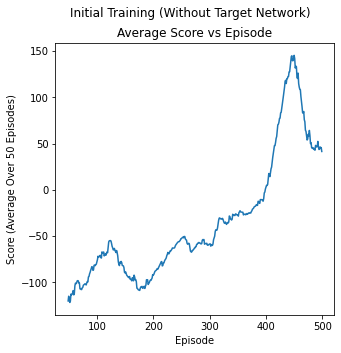

In [22]:
rolling_average = 50
avg_scores = pd.DataFrame(initial_training_data2['scores']).rolling(rolling_average).mean()

fig, (ax1) = plt.subplots(1, 1, figsize=(5,5))

ax1.plot(range(len(avg_scores)), avg_scores)

ax1.set_xlabel("Episode")
ax1.set_ylabel("Score (Average Over {} Episodes)".format(rolling_average))
ax1.set_title("Average Score vs Episode")

fig.suptitle('Initial Training (Without Target Network)')

plt.show()

# Tune Hyperparameters

In [7]:
env = gym.make('LunarLander-v2')
env.seed(1)

[1]

In [8]:
num_episodes = 500

target_update_interval = 10

rolling_average = 50

In [9]:
# Variable to change save path of data
run_name = '_{}'.format(num_episodes)

## Learning Rate

In [24]:
lrs = [0.05, 0.01, 0.005, 0.001, 0.0001]
lr_tuning_data = dict()

In [25]:
# num_episodes = 2500

learn_every_n = 1 # Change to learn every n instance

# Fixed parameter values
gamma=0.99
epsilon=1.0
epsilon_min=0.1
epsilon_decay=0.9999
batch_size=64
max_mem_size=100000

for lr in lrs:
    print('Learning Rate:', lr)
    
    lr_tuning_data[lr] = {'episode_index':[], 'scores':[], 'episode_train_times':[], 'epsilons':[],
        'gamma':gamma, 'epsilon_start':epsilon, 'epsilon_min':epsilon_min, 'epsilon_decay':epsilon_decay,
        'batch_size':batch_size, 'max_mem_size':max_mem_size, 'learn_every_n':learn_every_n, 'total_time':-1,
                         'target_update_interval':target_update_interval}
    
    tuning_agent = DQN_Agent(gamma=gamma, epsilon=epsilon, n_actions=4, input_size=8, lr=lr,
                  epsilon_min=epsilon_min, epsilon_decay=epsilon_decay,
                  batch_size=batch_size, max_mem_size=max_mem_size, target_update_interval=target_update_interval)
    

    counter = 0
    
    start_time = time.time()
    last_time = start_time
    for i in range(num_episodes):
        lr_tuning_data[lr]['episode_index'].append(i)
        
        score = 0
        done = False
        state = env.reset()
        while not done:
            action = tuning_agent.select_action(state)
            next_state, reward, done, info = env.step(action)
            score += reward
            tuning_agent.add_transition(state, action, reward, 
                                    next_state, done)
            state = next_state

            if counter % learn_every_n == 0:
                tuning_agent.learn()
            counter += 1
        lr_tuning_data[lr]['scores'].append(score)
        lr_tuning_data[lr]['epsilons'].append(tuning_agent.epsilon)
        
        current_time = time.time()
        lr_tuning_data[lr]['episode_train_times'].append(current_time-last_time)
        last_time = current_time

        avg_score = np.mean(lr_tuning_data[lr]['scores'][-100:])
        
        #print('\tEpisode: {} Score: {:.2f} Average Score: {:.2f}'.format(i, score, avg_score))
        
    lr_tuning_data[lr]['total_time'] = time.time()-start_time

Learning Rate: 0.05
Learning Rate: 0.01
Learning Rate: 0.005
Learning Rate: 0.001
Learning Rate: 0.0001


In [15]:
lr_json_file = 'lunar_lander_lr_tuning{}.json'.format(run_name)

In [27]:
# Save the data
with open(lr_json_file, 'w') as json_file:
    json.dump(lr_tuning_data, json_file)

In [16]:
# Load saved data
with open(lr_json_file, 'r') as json_file:
    lr_tuning_data = json.load(json_file)

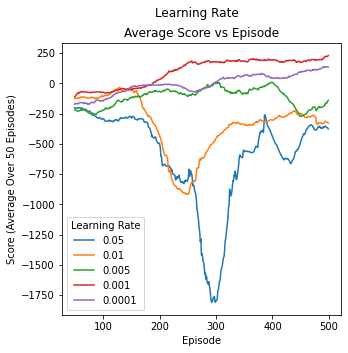

In [17]:
saved_lrs = [float(lr) for lr in lr_tuning_data.keys()]
saved_scores = {float(lr):[score for score in lr_tuning_data[lr]['scores']] for lr in lr_tuning_data.keys()}

# rolling_average = 500
avg_scores = {float(lr):pd.DataFrame(saved_scores[lr]).rolling(rolling_average).mean()
              for lr in saved_scores.keys()}



fig, (ax1) = plt.subplots(1, 1, figsize=(5,5))

for lr in saved_lrs:
    ax1.plot(range(len(avg_scores[lr])), avg_scores[lr], label=lr)

ax1.set_xlabel("Episode")
ax1.set_ylabel("Score (Average Over {} Episodes)".format(rolling_average))
ax1.set_title("Average Score vs Episode")
ax1.legend(title='Learning Rate')

fig.suptitle('Learning Rate')

plt.show()

## Epsilon Min

In [16]:
epsilon_mins = [0.2, 0.1, 0.05, 0.01, 0.005]
eps_min_tuning_data = dict()

In [17]:
# num_episodes = 2500

learn_every_n = 1 # Change to learn every n instance

# Fixed parameter values
gamma=0.99
epsilon=1.0
lr=0.001
epsilon_decay=0.9999
batch_size=64
max_mem_size=100000

for epsilon_min in epsilon_mins:
    print('Epsilon Min:', epsilon_min)
    
    eps_min_tuning_data[epsilon_min] = {'episode_index':[], 'scores':[], 'episode_train_times':[], 'epsilons':[],
        'lr':lr, 'gamma':gamma, 'epsilon_start':epsilon, 'epsilon_decay':epsilon_decay,
        'batch_size':batch_size, 'max_mem_size':max_mem_size, 'learn_every_n':learn_every_n, 'total_time':-1,
                                       'target_update_interval':target_update_interval}
    
    tuning_agent = DQN_Agent(gamma=gamma, epsilon=epsilon, n_actions=4, input_size=8, lr=lr,
                  epsilon_min=epsilon_min, epsilon_decay=epsilon_decay,
                  batch_size=batch_size, max_mem_size=max_mem_size, target_update_interval=target_update_interval)
    

    counter = 0
    
    start_time = time.time()
    last_time = start_time
    for i in range(num_episodes):
        eps_min_tuning_data[epsilon_min]['episode_index'].append(i)
        
        score = 0
        done = False
        state = env.reset()
        while not done:
            action = tuning_agent.select_action(state)
            next_state, reward, done, info = env.step(action)
            score += reward
            tuning_agent.add_transition(state, action, reward, 
                                    next_state, done)
            state = next_state

            if counter % learn_every_n == 0:
                tuning_agent.learn()
            counter += 1
        eps_min_tuning_data[epsilon_min]['scores'].append(score)
        eps_min_tuning_data[epsilon_min]['epsilons'].append(tuning_agent.epsilon)
        
        current_time = time.time()
        eps_min_tuning_data[epsilon_min]['episode_train_times'].append(current_time-last_time)
        last_time = current_time

        avg_score = np.mean(eps_min_tuning_data[epsilon_min]['scores'][-100:])
        
        #print('\tEpisode: {} Score: {:.2f} Average Score: {:.2f} Epsilon: {:.3f}'.format(i, score, avg_score, 
        #                                                            tuning_agent.epsilon))
        
    eps_min_tuning_data[epsilon_min]['total_time'] = time.time()-start_time

Epsilon Min: 0.2
Epsilon Min: 0.1
Epsilon Min: 0.05
Epsilon Min: 0.01
Epsilon Min: 0.005


In [19]:
eps_min_json_file = 'lunar_lander_eps_min_tuning{}.json'.format(run_name)

In [19]:
# Save the data
with open(eps_min_json_file, 'w') as json_file:
    json.dump(eps_min_tuning_data, json_file)

In [20]:
# Load saved data
with open(eps_min_json_file, 'r') as json_file:
    eps_min_tuning_data = json.load(json_file)

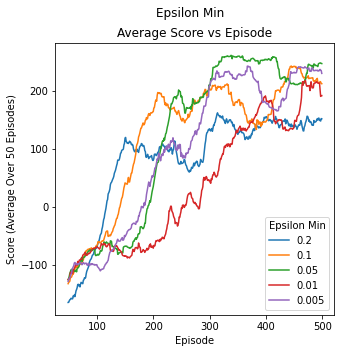

In [21]:
saved_eps_mins = [float(eps_min) for eps_min in eps_min_tuning_data.keys()]
saved_scores = {float(eps_min):[score for score in eps_min_tuning_data[eps_min]['scores']] 
                for eps_min in eps_min_tuning_data.keys()}

# rolling_average = 500
avg_scores = {float(eps_min):pd.DataFrame(saved_scores[eps_min]).rolling(rolling_average).mean()
              for eps_min in saved_scores.keys()}



fig, (ax1) = plt.subplots(1, 1, figsize=(5,5))

for eps_min in saved_eps_mins:
    ax1.plot(range(len(avg_scores[eps_min])), avg_scores[eps_min], label=eps_min)

ax1.set_xlabel("Episode")
ax1.set_ylabel("Score (Average Over {} Episodes)".format(rolling_average))
ax1.set_title("Average Score vs Episode")
ax1.legend(title='Epsilon Min')

fig.suptitle('Epsilon Min')

plt.show()

## Epsilon Decay

In [22]:
epsilon_decays = [0.999, 0.9999, 0.99995, 0.99999, 0.999999]
eps_decay_tuning_data = dict()

In [23]:
learn_every_n = 1 # Change to learn every n instance

# Fixed parameter values
gamma=0.99
epsilon=1.0
lr=0.001
epsilon_min=0.1
batch_size=64
max_mem_size=100000

for epsilon_decay in epsilon_decays:
    print('Epsilon Decay:', epsilon_decay)
    
    eps_decay_tuning_data[epsilon_decay] = {'episode_index':[], 'scores':[], 'episode_train_times':[], 'epsilons':[],
        'lr':lr, 'gamma':gamma, 'epsilon_start':epsilon, 'epsilon_min':epsilon_min,
        'batch_size':batch_size, 'max_mem_size':max_mem_size, 'learn_every_n':learn_every_n, 'total_time':-1,
                                           'target_update_interval':target_update_interval}
    
    tuning_agent = DQN_Agent(gamma=gamma, epsilon=epsilon, n_actions=4, input_size=8, lr=lr,
                  epsilon_min=epsilon_min, epsilon_decay=epsilon_decay,
                  batch_size=batch_size, max_mem_size=max_mem_size, target_update_interval=target_update_interval)
    

    counter = 0
    
    start_time = time.time()
    last_time = start_time
    for i in range(num_episodes):
        eps_decay_tuning_data[epsilon_decay]['episode_index'].append(i)
        
        score = 0
        done = False
        state = env.reset()
        while not done:
            action = tuning_agent.select_action(state)
            next_state, reward, done, info = env.step(action)
            score += reward
            tuning_agent.add_transition(state, action, reward, 
                                    next_state, done)
            state = next_state

            if counter % learn_every_n == 0:
                tuning_agent.learn()
            counter += 1
        eps_decay_tuning_data[epsilon_decay]['scores'].append(score)
        eps_decay_tuning_data[epsilon_decay]['epsilons'].append(tuning_agent.epsilon)
        
        current_time = time.time()
        eps_decay_tuning_data[epsilon_decay]['episode_train_times'].append(current_time-last_time)
        last_time = current_time

        avg_score = np.mean(eps_decay_tuning_data[epsilon_decay]['scores'][-100:])
        
        #print('\tEpisode: {} Score: {:.2f} Average Score: {:.2f} Epsilon: {:.2f}'.format(i, score, avg_score, 
        #                                                            tuning_agent.epsilon))
        
    eps_decay_tuning_data[epsilon_decay]['total_time'] = time.time()-start_time

Epsilon Decay: 0.999
Epsilon Decay: 0.9999
Epsilon Decay: 0.99995
Epsilon Decay: 0.99999
Epsilon Decay: 0.999999


In [11]:
eps_decay_json_file = 'lunar_lander_eps_decay_tuning{}.json'.format(run_name)

In [25]:
# Save the data
with open(eps_decay_json_file, 'w') as json_file:
    json.dump(eps_decay_tuning_data, json_file)

In [13]:
# Load saved data
with open(eps_decay_json_file, 'r') as json_file:
    eps_decay_tuning_data = json.load(json_file)

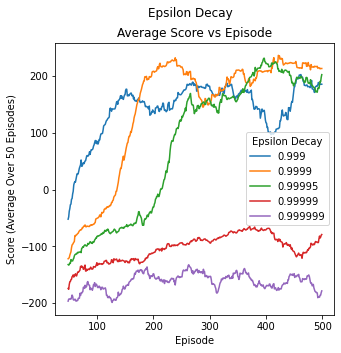

In [53]:
saved_eps_decays = [float(eps_decay) for eps_decay in eps_decay_tuning_data.keys()]
saved_scores = {float(eps_decay):[score for score in eps_decay_tuning_data[eps_decay]['scores']] 
                for eps_decay in eps_decay_tuning_data.keys()}

# rolling_average = 500
avg_scores = {float(eps_decay):pd.DataFrame(saved_scores[eps_decay]).rolling(rolling_average).mean()
              for eps_decay in saved_scores.keys()}



fig, (ax1) = plt.subplots(1, 1, figsize=(5,5))

for eps_decay in saved_eps_decays:
    ax1.plot(range(len(avg_scores[eps_decay])), avg_scores[eps_decay], label=eps_decay)

ax1.set_xlabel("Episode")
ax1.set_ylabel("Score (Average Over {} Episodes)".format(rolling_average))
ax1.set_title("Average Score vs Episode")
ax1.legend(title='Epsilon Decay')

fig.suptitle('Epsilon Decay')

plt.show()

## Gamma (Discount)

In [28]:
gammas = [0.9, 0.99, 0.999]
gamma_tuning_data = dict()

In [29]:
# num_episodes = 2500

learn_every_n = 1 # Change to learn every n instance

# Fixed parameter values
#gamma=0.99
epsilon=1.0
lr=0.001
epsilon_min=0.1
epsilon_decay=.9999
batch_size=64
max_mem_size=100000

for gamma in gammas:
    print('Gamma:', gamma)
    
    gamma_tuning_data[gamma] = {'episode_index':[], 'scores':[], 'episode_train_times':[], 'epsilons':[],
        'lr':lr, 'gamma':gamma, 'epsilon_start':epsilon, 'epsilon_min':epsilon_min,
        'batch_size':batch_size, 'max_mem_size':max_mem_size, 'learn_every_n':learn_every_n, 'total_time':-1,
                                           'target_update_interval':target_update_interval}
    
    tuning_agent = DQN_Agent(gamma=gamma, epsilon=epsilon, n_actions=4, input_size=8, lr=lr,
                  epsilon_min=epsilon_min, epsilon_decay=epsilon_decay,
                  batch_size=batch_size, max_mem_size=max_mem_size, target_update_interval=target_update_interval)
    

    counter = 0
    
    start_time = time.time()
    last_time = start_time
    for i in range(num_episodes):
        gamma_tuning_data[gamma]['episode_index'].append(i)
        
        score = 0
        done = False
        state = env.reset()
        while not done:
            action = tuning_agent.select_action(state)
            next_state, reward, done, info = env.step(action)
            score += reward
            tuning_agent.add_transition(state, action, reward, 
                                    next_state, done)
            state = next_state

            if counter % learn_every_n == 0:
                tuning_agent.learn()
            counter += 1
        gamma_tuning_data[gamma]['scores'].append(score)
        gamma_tuning_data[gamma]['epsilons'].append(tuning_agent.epsilon)
        
        current_time = time.time()
        gamma_tuning_data[gamma]['episode_train_times'].append(current_time-last_time)
        last_time = current_time

        avg_score = np.mean(gamma_tuning_data[gamma]['scores'][-100:])
        
        #print('\tEpisode: {} Score: {:.2f} Average Score: {:.2f} Epsilon: {:.2f}'.format(i, score, avg_score, 
        #                                                            tuning_agent.epsilon))
        
    gamma_tuning_data[gamma]['total_time'] = time.time()-start_time

Gamma: 0.9
Gamma: 0.99
Gamma: 0.999


In [22]:
gamma_json_file = 'lunar_lander_gamma_tuning{}.json'.format(run_name)

In [31]:
# Save the data
with open(gamma_json_file, 'w') as json_file:
    json.dump(gamma_tuning_data, json_file)

In [23]:
# Load saved data
with open(gamma_json_file, 'r') as json_file:
    gamma_tuning_data = json.load(json_file)

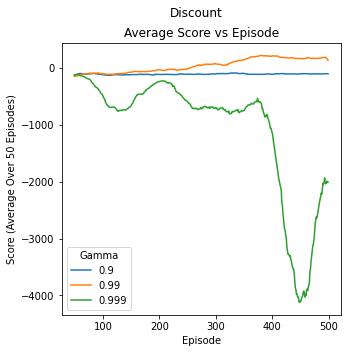

In [25]:
saved_gammas = [float(gamma) for gamma in gamma_tuning_data.keys()]
saved_scores = {float(gamma):[score for score in gamma_tuning_data[gamma]['scores']] 
                for gamma in gamma_tuning_data.keys()}

# rolling_average = 500
avg_scores = {float(gamma):pd.DataFrame(saved_scores[gamma]).rolling(rolling_average).mean()
              for gamma in saved_scores.keys()}



fig, (ax1) = plt.subplots(1, 1, figsize=(5,5))

for gamma in saved_gammas:
    ax1.plot(range(len(avg_scores[gamma])), avg_scores[gamma], label=gamma)

ax1.set_xlabel("Episode")
ax1.set_ylabel("Score (Average Over {} Episodes)".format(rolling_average))
ax1.set_title("Average Score vs Episode")
ax1.legend(title='Gamma')

fig.suptitle('Discount')

plt.show()

# Train the Tuned Agent

In [8]:
env = gym.make('LunarLander-v2')
env.seed(1)

[1]

In [9]:
final_agent = DQN_Agent(gamma=0.99, epsilon=1.0, n_actions=4, input_size=8, lr=0.001,
                  epsilon_min=0.05, epsilon_decay=0.9999,
                  batch_size=64, max_mem_size=100000, target_update_interval=10)

In [ ]:
tuned_training_data = {'scores':[], 'epsilons':[], 'gamma':final_agent.gamma, 'lr':final_agent.lr,
                         'epsilon_start':final_agent.epsilon, 'epsilon_min':final_agent.epsilon_min, 
                         'epsilon_decay':final_agent.epsilon_decay, 'batch_size':final_agent.batch_size,
                        'max_mem_size':final_agent.max_mem_size,
                         'target_update_itnerval':final_agent.target_update_interval}

scores = []

avg_scores = []
epsilons = []

n_games = 500
#n_games = 50

tuned_training_data['episodes'] = n_games

print_prev_n = 20

learn_n = 1
counter = 0
for i in range(n_games):
    score = 0
    done = False
    state = env.reset()
    while not done:
        action = final_agent.select_action(state)
        next_state, reward, done, info = env.step(action)
        score += reward
        final_agent.add_transition(state, action, reward, 
                                next_state, done)
        state = next_state
        
        if counter % learn_n == 0:
            final_agent.learn()
        counter += 1
    scores.append(score)
    #eps_history.append(final_agent.epsilon)

    avg_score = np.mean(scores[-100:])
    avg_scores.append(avg_score)
    
    #epsilons.append(final_agent.epsilon)
    
    tuned_training_data['scores'].append(score)
    tuned_training_data['epsilons'].append(final_agent.epsilon)

    print('Episode: {} \tScore: {:.2f} \tAverage Score: {:.2f} \tEpsilon: {:.2f}'.format(
                 i, scores[i], avg_scores[i], tuned_training_data['epsilons'][i]))
#     clear_output(wait=True)
#     for j in range(print_prev_n, -1, -1):
#         if i-j < len(scores) and i-j >= 0:
#             print('Episode: {} Score: {:.2f} Average Score: {:.2f} Epsilon: {:.2f}'.format(
#                 i-j, scores[i-j], avg_scores[i-j], epsilons[i-j]))
    
#     print('episode ', i, 'score %.2f' % score,
#             'average score %.2f' % avg_score,
#             'epsilon %.2f' % agent.epsilon)

In [54]:
# Save model
q_policy_tuned_save_path = "Q_policy_tuned_model.pt"

torch.save(final_agent.Q_policy_nn.state_dict(), q_policy_tuned_save_path)

In [ ]:
# Load model
q_policy_tuned_save_path = "Q_policy_tuned_model.pt"

final_agent.Q_policy_nn.load_state_dict(torch.load(q_policy_tuned_save_path))

In [61]:
tuned_train_file = 'tuned_model.json'

In [56]:
# Save the data
with open(tuned_train_file, 'w') as json_file:
    json.dump(tuned_training_data, json_file)

In [62]:
# Load saved data
with open(tuned_train_file, 'r') as json_file:
    tuned_training_data = json.load(json_file)

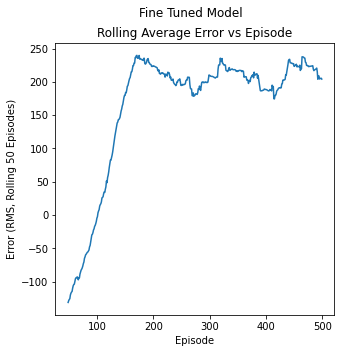

In [65]:
rolling_average = 50
avg_scores = pd.DataFrame(tuned_training_data['scores']).rolling(rolling_average).mean()

fig, (ax1) = plt.subplots(1, 1, figsize=(5,5))

ax1.plot(range(len(avg_scores)), avg_scores)

ax1.set_xlabel("Episode")
ax1.set_ylabel("Error (RMS, Rolling {} Episodes)".format(rolling_average))
ax1.set_title("Rolling Average Error vs Episode")

fig.suptitle('Fine Tuned Model')

plt.show()

In [64]:
print('Final Average Score:', float(avg_scores.iloc[-1]))

Final Average Score: 215.71341245094186


## Train Tuned Agent Only Until Average Score 200 over 100 episodes

In [17]:
env = gym.make('LunarLander-v2')
env.seed(1)

[1]

In [18]:
final_agent = DQN_Agent(gamma=0.99, epsilon=1.0, n_actions=4, input_size=8, lr=0.001,
                  epsilon_min=0.05, epsilon_decay=0.99995,
                  batch_size=64, max_mem_size=100000, target_update_interval=10)

In [ ]:
tuned_training_data = {'scores':[], 'epsilons':[], 'gamma':final_agent.gamma, 'lr':final_agent.lr,
                         'epsilon_start':final_agent.epsilon, 'epsilon_min':final_agent.epsilon_min, 
                         'epsilon_decay':final_agent.epsilon_decay, 'batch_size':final_agent.batch_size,
                        'max_mem_size':final_agent.max_mem_size,
                         'target_update_itnerval':final_agent.target_update_interval}

scores = []

avg_scores = []
epsilons = []

n_games = 500
#n_games = 50

tuned_training_data['episodes'] = n_games

print_prev_n = 20

learn_n = 1
counter = 0
for i in range(n_games):
    score = 0
    done = False
    state = env.reset()
    while not done:
        action = final_agent.select_action(state)
        next_state, reward, done, info = env.step(action)
        score += reward
        final_agent.add_transition(state, action, reward, 
                                next_state, done)
        state = next_state
        
        if counter % learn_n == 0:
            final_agent.learn()
        counter += 1
    scores.append(score)
    #eps_history.append(final_agent.epsilon)

    avg_score = np.mean(scores[-100:])
    avg_scores.append(avg_score)
    
    #epsilons.append(final_agent.epsilon)
    
    tuned_training_data['scores'].append(score)
    tuned_training_data['epsilons'].append(final_agent.epsilon)

    print('Episode: {} \tScore: {:.2f} \tAverage Score: {:.2f} \tEpsilon: {:.2f}'.format(
                 i, scores[i], avg_scores[i], tuned_training_data['epsilons'][i]))
    
    if avg_score >= 200:
        break

In [20]:
# Save model
q_policy_tuned_save_path = "Q_policy_tuned_model2.pt"

torch.save(final_agent.Q_policy_nn.state_dict(), q_policy_tuned_save_path)

In [21]:
# Load model
q_policy_tuned_save_path = "Q_policy_tuned_model2.pt"

final_agent.Q_policy_nn.load_state_dict(torch.load(q_policy_tuned_save_path))

<All keys matched successfully>

In [10]:
tuned_train_file = 'tuned_model2.json'

In [23]:
# Save the data
with open(tuned_train_file, 'w') as json_file:
    json.dump(tuned_training_data, json_file)

In [11]:
# Load saved data
with open(tuned_train_file, 'r') as json_file:
    tuned_training_data = json.load(json_file)

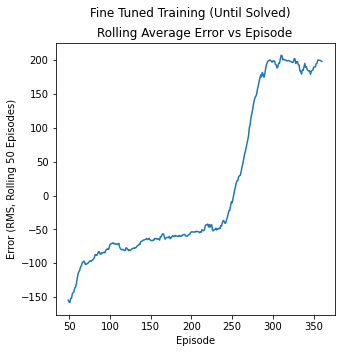

In [12]:
rolling_average = 50
avg_scores = pd.DataFrame(tuned_training_data['scores']).rolling(rolling_average).mean()

fig, (ax1) = plt.subplots(1, 1, figsize=(5,5))

ax1.plot(range(len(avg_scores)), avg_scores)

ax1.set_xlabel("Episode")
ax1.set_ylabel("Error (RMS, Rolling {} Episodes)".format(rolling_average))
ax1.set_title("Rolling Average Error vs Episode")

fig.suptitle('Fine Tuned Training (Until Solved)')

plt.show()

In [44]:
print('Final Average Score:', float(avg_scores.iloc[-1]))

Final Average Score: 202.62434983608048


## Analysis on the Tuned Agent

In [40]:
# Load model
if 'final_agent' not in locals():
    final_agent = DQN_Agent(gamma=0.99, epsilon=1.0, n_actions=4, input_size=8, lr=0.001,
                  epsilon_min=0.01, epsilon_decay=0.99995,
                  batch_size=64, max_mem_size=100000, target_update_interval=10)

q_policy_tuned_save_path = "Q_policy_tuned_model.pt"

final_agent.Q_policy_nn.load_state_dict(torch.load(q_policy_tuned_save_path))

<All keys matched successfully>

In [41]:
env = gym.make('LunarLander-v2')
env.seed(1)

[1]

In [42]:
model = final_agent.Q_policy_nn
model.device = torch.device('cpu')
model.to(model.device)

DQN(
  (layer1): Linear(in_features=8, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=4, bias=True)
  (loss): MSELoss()
)

### Test Model for 100 Episodes

In [43]:
num_episodes = 100

In [ ]:
model_data = {'frames':[], 'scores':[], 'frame_scores':[], 'accumulated_frame_scores':[]}

save_frames = False
for episode in range(num_episodes):
    print('Episode:', episode)
    
    score = 0
    frames = []
    frame_score = [0]
    accumulated_frame_scores = [0]
    
    state = env.reset()
    
    if save_frames:
        frames.append(env.render(mode="rgb_array"))
    
    #state = np.array(state, dtype=np.float32)
    state = torch.FloatTensor(state).to(model.device)
    prediction = model(state)
    
    done = False
    while not done:
        action = np.argmax(model(state).detach().numpy())
        next_state, reward, done, info = env.step(action)
        score += reward
        state = torch.FloatTensor(next_state).to(model.device)
        
        if save_frames:
            frame_score.append(reward)
            frames.append(env.render(mode="rgb_array"))
            accumulated_frame_scores.append(score)
        
    model_data['frames'].append(frames)
    model_data['scores'].append(score)
    model_data['frame_scores'].append(frame_score)
    model_data['accumulated_frame_scores'].append(accumulated_frame_scores)

In [14]:
model_data_path = 'model_data.json'

In [46]:
# Save the data
with open(model_data_path, 'w') as json_file:
    json.dump(model_data, json_file)

In [15]:
# Load saved data
with open(model_data_path, 'r') as json_file:
    model_data = json.load(json_file)

In [48]:
if save_frames: # Frames cannot be easily saved.  This should only run if episodes were generated.
    episode = 0

    frames = model_data['frames'][episode]
    #accumulated_frame_score =  model_data['accumulated_frame_scores'][episode]

    fig, (ax) = plt.subplots(figsize=(frames[0].shape[1]/70, frames[0].shape[0]/70), dpi=72)
    plt.axis('off')

    current_frame = plt.imshow(frames[0])

    def animate(frame):
        current_frame.set_data(frames[frame])
        #plt.text(0, 0, accumulated_frame_score[frame], color='r')
        #ax.annotate('Accumulated Score: {:.2f}'.format(accumulated_frame_score[frame]), (1,1), color='red')

    anim = animation.FuncAnimation(fig, animate, frames = len(frames), interval=1000/60)
    plt.close()
    HTML(anim.to_html5_video())

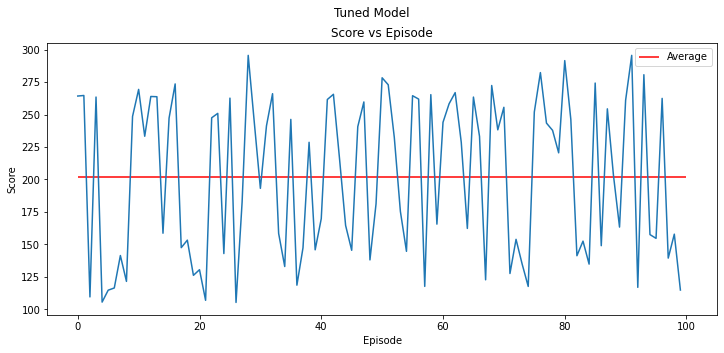

In [24]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12,5))

ax1.plot(range(len(model_data['scores'])), model_data['scores'])

ax1.set_xlabel("Episode")
ax1.set_ylabel("Score")
ax1.set_title("Score vs Episode")
ax1.hlines(y=np.mean(model_data['scores']), xmin=0, xmax=len(model_data['scores']), color='r', label='Average')
ax1.legend()

fig.suptitle('Tuned Model')

plt.show()

In [52]:
print(np.mean(model_data['scores']))

202.2274824788616


In [26]:
count = 0
for i in model_data['scores']:
    if i > 200:
        count+=1
print('Number of samples above 200:', count)

Number of samples above 200: 53
